# Building model with deep learning

Isolate the Rossmann Store Sales dataset into time series data

In [1]:
import pandas as pd

# Load the dataset
file = r'C:\data science material\project_6\Notebook\cleaned_train_store_data.csv'
data = pd.read_csv(file)

# Convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter the relevant columns and group by Date and Store, aggregating Sales
time_series_data = data[['Date', 'Store', 'Sales']].groupby(['Date', 'Store']).sum().reset_index()

# Set 'Date' as the index for time series operations (optional but helpful)
time_series_data.set_index('Date', inplace=True)

# Display the first few rows
print(time_series_data.head())


            Store  Sales
Date                    
2013-01-01      1      0
2013-01-01      2      0
2013-01-01      3      0
2013-01-01      4      0
2013-01-01      5      0


 Check whether your time series data is stationary

In [2]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts):
    result = adfuller(ts)
    return result[1]  # p-value

# Check stationarity for a specific store (e.g., Store 1)
store_1_data = time_series_data[time_series_data['Store'] == 1]['Sales']
p_value = check_stationarity(store_1_data)
print(f"Store 1 ADF p-value: {p_value}")

Store 1 ADF p-value: 0.0003378834614142489


Difference your time series data if not stationary

In [3]:
if p_value > 0.05:
    store_1_data_diff = store_1_data.diff().dropna()
else:
    store_1_data_diff = store_1_data

Check for autocorrelation and partial autocorrelation

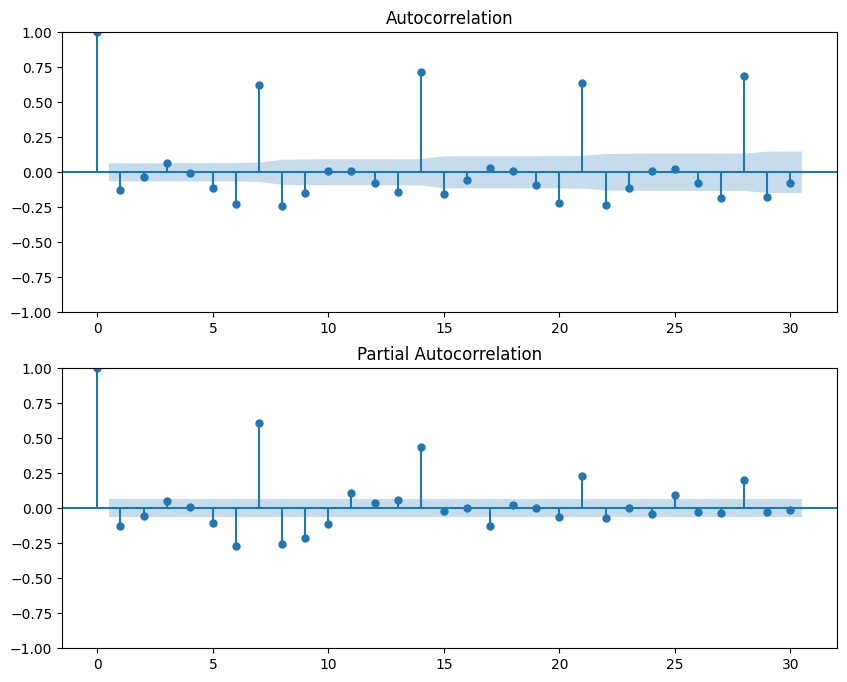

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt 
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(store_1_data_diff, ax=ax[0])
plot_pacf(store_1_data_diff, ax=ax[1])
plt.show()

The autocorrelation (ACF) and partial autocorrelation (PACF) plots show that there are significant spikes at certain lags. This suggests that past values up to around lag 5 and specific other lags could influence the current value. For a time series model, consider using an ARIMA model with parameters based on these lags to capture the autocorrelation pattern effectively.


Transform the time series data into supervised learning data

In [5]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Define the time step
time_step = 10
X, y = create_dataset(store_1_data_diff.values, time_step)

Scale your data in the (-1, 1) range

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Reshape input to be [samples, time steps, features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

Build an LSTM Regression model to predict the next sale

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_scaled.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_scaled, y_scaled, epochs=50, batch_size=32)


c:\data science material\project_6\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.1865
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1803
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1801
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1787
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1872
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1788
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1767
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1791
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1782
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1841
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1697
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1644
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1800
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1717
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1668
Epo

In [8]:
# Reshape input to be [samples, time steps, features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [9]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_scaled.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

In [10]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# Fit the model
history = model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.1896 - val_loss: 0.1633
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1767 - val_loss: 0.1568
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1798 - val_loss: 0.1543
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1915 - val_loss: 0.1547
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1824 - val_loss: 0.1591
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1805 - val_loss: 0.1521
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1880 - val_loss: 0.1529
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1761 - val_loss: 0.1539
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1765 - val_loss: 0.1581
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1720 - val_loss: 0.1562
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1778 - val_loss: 0.1519
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.17

In [12]:
# Save the model
model.save("rossmann_sales_lstm_model.h5")

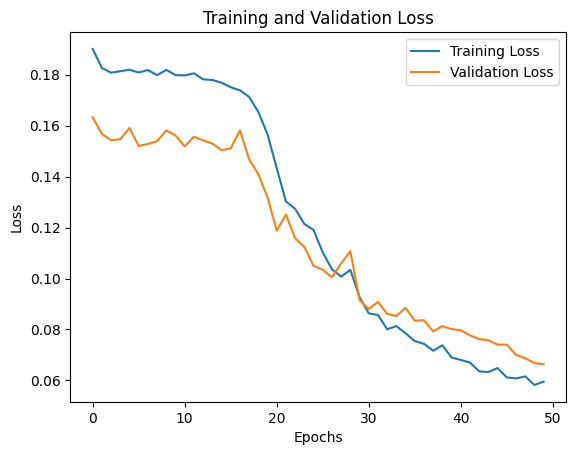

In [13]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The graph shows that both training and validation loss decrease steadily, indicating the model is learning well. After around 30 epochs, the validation loss begins to level out, showing that additional training brings minimal improvement. This suggests the model is well-trained, and further training may not significantly enhance performance. To optimize, consider early stopping at around 30 epochs to save computation time.

In [14]:
# Load model and predict on the training data (for visualization purposes)
from tensorflow.keras.models import Sequential, load_model
model = load_model("rossmann_sales_lstm_model.h5")
train_predict = model.predict(X_scaled)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


In [15]:
# Inverse scale the predictions for plotting
train_predict_inverse = scaler.inverse_transform(train_predict)
y_scaled_inverse = scaler.inverse_transform(y_scaled)

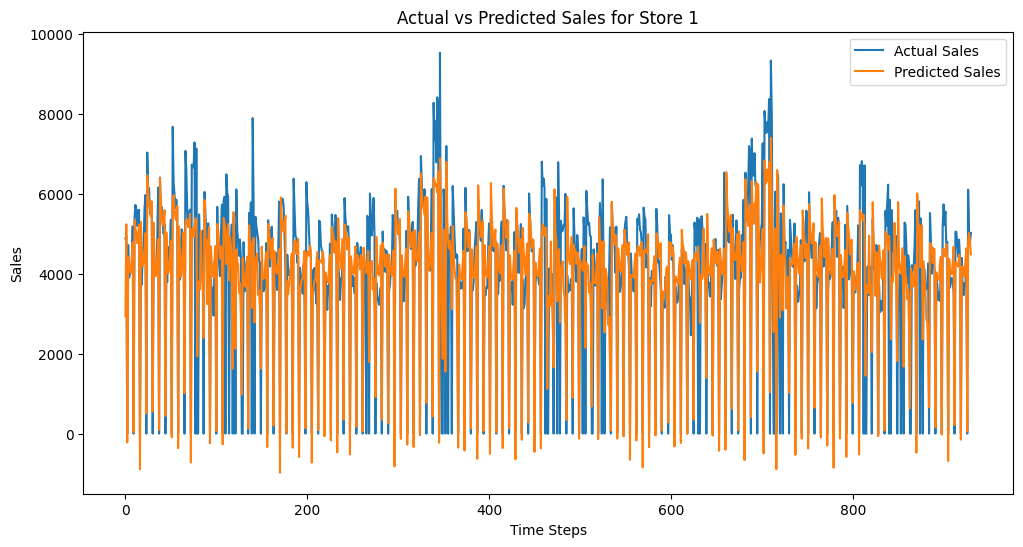

In [16]:
# Plot actual vs. predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_scaled_inverse, label='Actual Sales')
plt.plot(train_predict_inverse, label='Predicted Sales')
plt.title('Actual vs Predicted Sales for Store 1')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()

The graph shows that predicted sales closely follow the actual sales trend, although there are several instances where the predicted values fluctuate more than actual values. This suggests the model is reasonably accurate but may sometimes overestimate or underestimate sales. To improve accuracy, consider fine-tuning the model or using additional data features.